(4, 500)


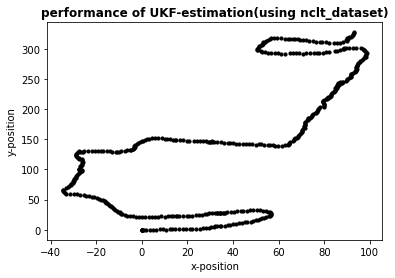

In [5]:
import numpy as np
import scipy
from numpy.random import randn
import numpy as np
from scipy.linalg import sqrtm
import math
import matplotlib.pyplot as plt
import csv

def parameter_sigmapoints(n,alpha,beta,kappa):
    '''
    n : dimension of state vector
    alpha,beta,kappa : manually set up patamaters
    wm : weight matrix for calculating mean
    wc : weight matrix for calculating variance
    U : a parameter for computation convenience
    '''
    lamb=alpha**2*(n+kappa)-n
    wm=[lamb/(n+lamb)]
    wc=[(lamb/(lamb+n))+(1-alpha**2+beta)]
    for i in range(2*n):
        wm.append(1/(2*(n+lamb)))
        wc.append(1/(2*(n+lamb)))
    U=math.sqrt(n+lamb)
    U=np.array([U])
    wm=np.array([wm])
    wc=np.array([wc])
    return wm,wc,U


def generate_sigmapoints(xEst, PEst, U):
    '''
    xEst:mean of initial data
    PEst:variance of initial data
    U:U=sqrt(n+lamb)
    '''
    sigma = xEst
    Psqrt = scipy.linalg.sqrtm(PEst)
    # Psqrt=scipy.linalg.cholesky(PEst)
    n = len(xEst[:, 0])
    for i in range(n):
        sigma = np.hstack((sigma, xEst + U * Psqrt[:, i:i + 1]))
    for i in range(n):
        sigma = np.hstack((sigma, xEst - U * Psqrt[:, i:i + 1]))
    return sigma


def transform_sigma_motion(sigma):
    """
        Sigma Points prediction with motion model
    """
    for i in range(sigma.shape[1]):
        sigma[:, i:i + 1] = f(sigma[:, i:i + 1], dt)

    return sigma


def transform_sigma_observation(sigma):
    """
        Sigma Points prediction with observation model
    """
    sigma_obs = np.zeros((2, sigma.shape[1]))
    for i in range(sigma.shape[1]):
        sigma_obs[:, i] = h(sigma[:, i])
    return sigma_obs


def covariance_prior(x, sigma, wc, Pi):
    '''

    '''
    nSigma = sigma.shape[1]

    d = sigma - x[0:sigma.shape[0]]
    # print('d ist',d)
    P = Pi
    for i in range(nSigma):
        P = P + wc[0, i] * d[:, i:i + 1] @ d[:, i:i + 1].T
    return P


def calc_pxz(sigma, x, z_sigma, zb, wc):
    '''

    '''
    nSigma = sigma.shape[1]
    dx = sigma - x
    dz = z_sigma - zb[0:2]
    P = np.zeros((dx.shape[0], dz.shape[0]))

    for i in range(nSigma):
        P = P + wc[0, i] * dx[:, i:i + 1] @ dz[:, i:i + 1].T
    return P


def ukf_estimation(xEst, PEst, z, wm, wc, gamma):
    '''
    z: observation with noise
    wm, wc, gamma: constant parameters
    '''
    #  Predict process
    # generate sigma points
    sigma = generate_sigmapoints(xEst, PEst, gamma)
    sigma = transform_sigma_motion(sigma)
    # prediction of mean of input
    xPred = (wm @ sigma.T).T
    # estimate of covariance
    PPred = covariance_prior(xPred, sigma, wc, Q)

    #  Update process

    #  generate new sigma points after prediction
    sigma = generate_sigmapoints(xPred, PPred, gamma)
    # transform sigma points with observation model
    z_sigma = transform_sigma_observation(sigma)
    # mean
    zPred = (wm @ z_sigma.T).T
    #  Pz_matrix
    st = covariance_prior(zPred, z_sigma, wc, R)
    Pxz = calc_pxz(sigma, xPred, z_sigma, zPred, wc)
    # kalman gain
    K = Pxz @ np.linalg.inv(st)
    y = z - zPred
    # update the estimate value：
    xEst = xPred + K @ y
    # update the covariance：
    PEst = PPred - K @ st @ K.T
    return xEst, PEst


def f(x,dt):
    '''
    state vector[x,y,x_dot,y_dot]
    accelaration(or control input) is modified as a gaussian noise process
    '''
    A=np.array([[0,0,dt,0],
            [0,0,0,dt],
            [0,0,0,0],
            [0,0,0,0]])
    B=np.array([[0,0],
            [0,0],
            [dt,0],
            [0,dt]])
    U=np.zeros(shape=(2,1))
    U[0:1,0:1]=np.random.normal(0,0.02, size=(1,1))
    U[1:2,0:1]=np.random.normal(0,0.02, size=(1,1))

    return  np.dot(A,x)+np.dot(B,U)+x


def h(x):
    '''
    observation model,velocity v_x v_y is the noisy reading
    '''
    H=np.array([[0,0,1,0],
                [0,0,0,1]])
    return np.dot(H,x)

#time step
dt=1
#parameter q and r of the covariance of matrix Q and R, which can be optimized through a grid search
q=1
r=1

Q=np.array([dt,dt,dt,dt])
Q=q**2*np.diag(Q)
R = np.diag([r, r]) ** 2

#read the absolute velocity of the robot using the wheel velocity file
# v=0.5*(v_right+v_left)

with open('C:/Users/85193/PycharmProjects/UnKF_beispiel/wheels.csv','r',encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    rows= [row for row in reader]
    wheels_data = np.array(rows)
    #print(wheels_data[5,1])
#print(wheels_data.shape)
v_right=wheels_data[:,1].reshape(500,1).astype(float)
v_left=wheels_data[:,2].reshape(500,1).astype(float)
v=(v_right+v_left)*0.5
#print(v.shape)

with open('C:/Users/85193/PycharmProjects/UnKF_beispiel/kvh.csv','r',encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    rows= [row for row in reader]
    kvh_data = np.array(rows)
    #print(kvh_data[0,0])
radians=kvh_data[:,1].astype(float).reshape(500,1)
vx= np.multiply(v,np.cos(radians))
vy= np.multiply(v,np.sin(radians))
vel=np.append(vx,vy,axis=1) #z.shape=(500,2)

xEst = np.zeros((4, 1)) .reshape(4,1)#default initial state
n = 4  # dimension of State Vector [x x_dot y y_dot]'
PEst = np.eye(n) # initial of the covariance matrix
n=4
alpha=.1
beta=2.
kappa=1.
wm, wc, gamma = parameter_sigmapoints(n,alpha,beta,kappa)
hxEst = xEst
for i in range(499):
    # np.random.seed()
    z=np.array(vel[i,:]).reshape(2,1)
    xEst, PEst = ukf_estimation(xEst, PEst, z, wm, wc, gamma)
    hxEst = np.hstack((hxEst, xEst))
print(hxEst.shape)


plt.figure(2)
plt.scatter(hxEst[0,:],hxEst[1,:],color='black',s=10,label="nonlinear-Estimation")
plt.title('performance of UKF-estimation(using nclt_dataset)',fontsize='large',fontweight='bold')
plt.xlabel('x-position')
plt.ylabel('y-position')
plt.show()